## Chargement du dataset des 2 lunes


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

def generate_2moons_dataset(num_lab = 10, num_unlab=740, num_test=250):
  num_samples = num_lab + num_unlab + num_test
  # Génération de 1000 données du dataset des 2 lunes
  x, y = datasets.make_moons(n_samples=num_samples, noise=0.1, random_state=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=num_test/num_samples, random_state=1)
  x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=num_unlab/(num_unlab+num_lab), random_state=6)

  return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test

(10, 2) (740, 2) (250, 2)
(10,) (740,) (250,)


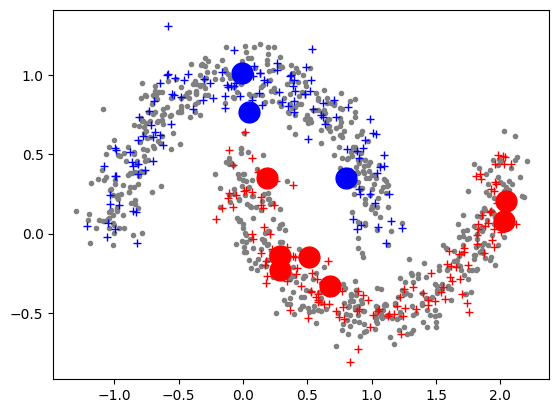

In [2]:
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_2moons_dataset(num_lab = 10, num_unlab=740, num_test=250)

print(x_train_lab.shape, x_train_unlab.shape, x_test.shape)
print(y_train_lab.shape, y_train_unlab.shape, y_test.shape)

# Affichage des données
plt.plot(x_train_unlab[y_train_unlab==0,0], x_train_unlab[y_train_unlab==0,1], color=(0.5,0.5,0.5), marker='.', linestyle=' ')
plt.plot(x_train_unlab[y_train_unlab==1,0], x_train_unlab[y_train_unlab==1,1], color=(0.5,0.5,0.5), marker='.', linestyle=' ')

plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+')

plt.plot(x_train_lab[y_train_lab==0,0], x_train_lab[y_train_lab==0,1], 'b.', markersize=30)
plt.plot(x_train_lab[y_train_lab==1,0], x_train_lab[y_train_lab==1,1], 'r.', markersize=30)

plt.show()

In [3]:
def create_model_2moons():

  inputs = keras.Input(shape=(2,))
  x = Dense(20, activation="relu")(inputs)
  outputs = Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

# $\Pi$-Modèle

Nous allons maintenant tenter d'utiliser un 2nd algorithme semi-supervisé supposé être plus efficace, il s'agit de l'algorithme du $\Pi$-Modèle, dont la version détaillée est reprise ci-dessous de l'article (en VO).

<img src="https://drive.google.com/uc?id=13VhlBYwA6YIYGzKI81Jom_jTiuhOypEg">
<caption><center> Figure 1 : Pseudo-code de l'algorithme du $\Pi$-Modèle</center></caption>


Ci-dessous, la boucle d'entraînement détaillée est reprise et contient un squelette du code à réaliser pour implémenter le $\Pi$-Modèle.

**Travail à faire :** Complétez le squelette de l'algorithme du $\Pi$-Modèle pour pouvoir tester ce nouvel algorithme.

In [5]:
import keras
from keras.layers import Dense
import tensorflow as tf

In [17]:
# Nombre d'epochs de l'apprentissage
epochs = 1000
# Nombre de données non-labellisées par batch
bs_unlab = 100
# Nombre de données labellisées par batch
bs_lab = 10
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_2moons_dataset(num_lab = 10, num_unlab=740, num_test=250)
model = create_model_2moons()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.BinaryCrossentropy()
# L'autre pour la partie non-supervisée de la perte
loss_unsup = keras.losses.MeanSquaredError()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch alternatif constitué des mêmes données bruitées
    # Le bruit ici sera simplement obtenu avec np.random.rand()
    # Attention à l'échelle du bruit (il faut le multiplier par un scalaire pour qu'il ne sois pas trop important)!
    noise_weight = 0.25
    x_batch_noisy = x_batch + noise_weight * np.random.rand(batch_size,2)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !
      y_pred_noisy = model(x_batch_noisy, training=True)

      # Calcul de la fonction de perte sur ce batch
      sup_term = loss_sup(y_batch_lab, y_pred[:bs_lab])
      unsup_term = loss_sup(y_pred[bs_lab:], y_pred_noisy[bs_lab:])

      loss_value = (1/batch_size) * sup_term + (lambda_t/bs_unlab) * unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_state()
  val_acc_metric.reset_state()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 100:
      lambda_t = lambda_t + 0.01




Epoch    0 : Loss : 0.0068, Acc : 0.1000, Val Acc : 0.4680
Epoch    1 : Loss : 0.0065, Acc : 0.5000, Val Acc : 0.6840
Epoch    2 : Loss : 0.0062, Acc : 0.8000, Val Acc : 0.7560
Epoch    3 : Loss : 0.0059, Acc : 0.9000, Val Acc : 0.7600
Epoch    4 : Loss : 0.0057, Acc : 0.9000, Val Acc : 0.7720
Epoch    5 : Loss : 0.0055, Acc : 0.9000, Val Acc : 0.8040
Epoch    6 : Loss : 0.0053, Acc : 0.9000, Val Acc : 0.8200
Epoch    7 : Loss : 0.0051, Acc : 0.9000, Val Acc : 0.8280
Epoch    8 : Loss : 0.0049, Acc : 0.9000, Val Acc : 0.8280
Epoch    9 : Loss : 0.0047, Acc : 0.9000, Val Acc : 0.8280
Epoch   10 : Loss : 0.0045, Acc : 0.9000, Val Acc : 0.8280
Epoch   11 : Loss : 0.0044, Acc : 0.9000, Val Acc : 0.8320
Epoch   12 : Loss : 0.0043, Acc : 0.9000, Val Acc : 0.8280
Epoch   13 : Loss : 0.0041, Acc : 0.9000, Val Acc : 0.8280
Epoch   14 : Loss : 0.0040, Acc : 0.9000, Val Acc : 0.8280
Epoch   15 : Loss : 0.0039, Acc : 0.9000, Val Acc : 0.8280
Epoch   16 : Loss : 0.0038, Acc : 0.9000, Val Acc : 0.83

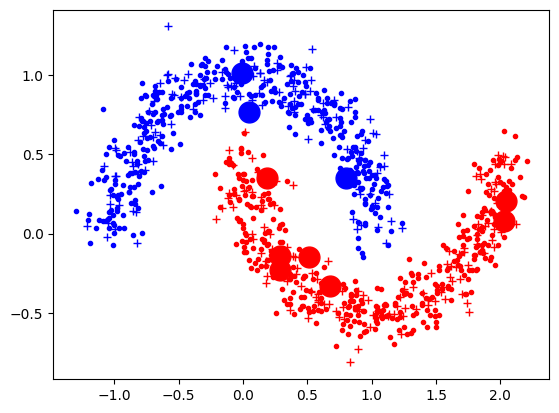

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


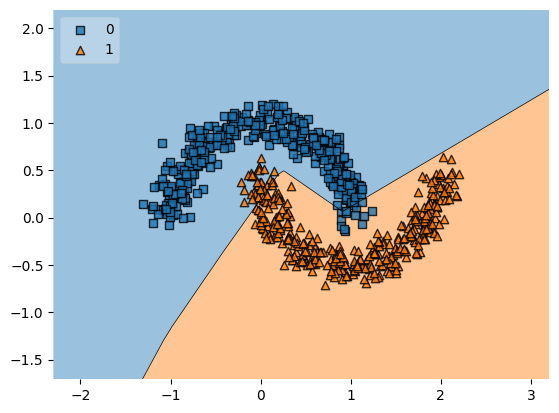

In [18]:
from mlxtend.plotting import plot_decision_regions

# Affichage des données
plt.plot(x_train_unlab[y_train_unlab==0,0], x_train_unlab[y_train_unlab==0,1], 'b.')
plt.plot(x_train_unlab[y_train_unlab==1,0], x_train_unlab[y_train_unlab==1,1], 'r.')

plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+')

plt.plot(x_train_lab[y_train_lab==0,0], x_train_lab[y_train_lab==0,1], 'b.', markersize=30)
plt.plot(x_train_lab[y_train_lab==1,0], x_train_lab[y_train_lab==1,1], 'r.', markersize=30)

plt.show()

# Plot decision boundary
plot_decision_regions(x_train_unlab, y_train_unlab, clf=model, legend=2)
plt.show()

Vous devriez observer des résultats bien meilleurs (pas complètement parfaits) sur le dataset des 2 lunes.

# MNIST

Pour adapter l'algorithme du $\Pi$-modèle à MNIST, nous allons devoir remplacer le bruitage des données par de l'augmentation de données.

Commencez par remplir l'ImageDataGenerator (à vous de voir comment dans [la documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)) avec des transformations pertinentes. **Attention** cette étape est cruciale pour obtenir de bons résultats. Il faut intégrer les augmentations les plus fortes possibles, mais être certain qu'elles ne modifient pas le label du chiffre ! (par exemple, un rotation de 180° transforme un 6 en 9 !)

In [19]:
from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split

def generate_mnist_dataset(num_lab = 100):

  # Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = np.expand_dims(x_train.astype('float32') / 255., 3)
  x_test = np.expand_dims(x_test.astype('float32') / 255., 3)

  x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=(x_train.shape[0]-num_lab)/x_train.shape[0], random_state=2)

  return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test

x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


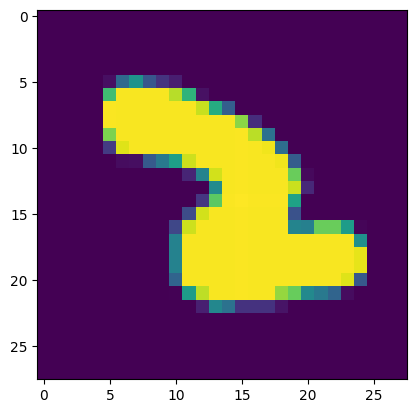

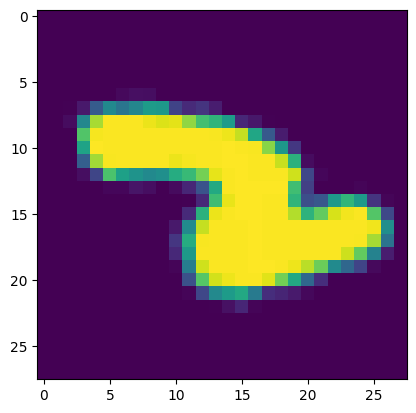

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=90,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.3,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

# Affichage d'une donnée et de son augmentation
x = x_train_lab[0:10]
plt.imshow(x[0, : ,: ,0])
plt.show()
x_aug = train_datagen.flow(x, shuffle=False, batch_size=10).__next__()
plt.imshow(x_aug[0, : ,: ,0])
plt.show()

Implémentez le réseau LeNet-5 pour la classifications des chiffres manuscrits, en suivant cet exemple :    
<img src="https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg">
<caption><center> Figure 2 : Schéma de l'architecture de LeNet-5</center></caption>

In [44]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

In [45]:
# A COMPLETER
# Ici, on implémentera le modèle LeNet-5 :
# 1 couche de convolution 5x5 à 6 filtres suivie d'un max pooling
# puis 1 couche de convolution 5x5 à 16 filtres suivie d'un max pooling et d'un Flatten
# Enfin 2 couches denses de 120 et 84 neurones, avant la couche de sortie à 10 neurones.
def create_model_mnist():

  inputs = keras.Input(shape=(...))

  conv1 = Conv2D(6, 5, activation="relu")(inputs)
  pool1 = MaxPool2D((2,2))(conv1)
  conv2 = Conv2D(16, 5, activation="relu")(pool1)
  pool2 = MaxPool2D((2,2))(conv2)
  flat = Flatten()(pool2)
  dense1 = Dense(120)(flat, activation="relu")
  dense2 = Dense(84)(dense1, activation="relu")

  outputs = Dense(10)(dense2, activation="softmax")

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

**Travail à faire**

Commencez d'abord par entraîner LeNet-5 sur MNIST de manière supervisée, en **utilisant 100 données labellisées**.

Attention, il va vous falloir modifier quelques élements par rapport à ce que nous avons fait dans la séance précédente, notamment la fonction de coût (*SparseCategoricalCrossEntropy*) et les métriques (*SparseCategoricalAccuracy*).

Pour comparer de manière juste les versions supervisée et semi-supervisée, n'oubliez pas également d'intégrer l'augmentation de données dans votre apprentissage. Vous devriez obtenir environ 80\% de bonnes classifications sur l'ensemble de test.

In [58]:
# Nombre d'epochs de l'apprentissage
epochs = 1000
# Nombre de données non-labellisées par batch
bs_unlab = 0
# Nombre de données labellisées par batch
bs_lab = 100
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset()
model = create_model_2moons()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
# L'une pour la partie supervisée de la perte
loss_sup = tf.keras.losses.SparseCategoricalCrossentropy()
# L'autre pour la partie non-supervisée de la perte
loss_unsup = keras.losses.MeanSquaredError()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch alternatif constitué des mêmes données bruitées
    # Le bruit ici sera simplement obtenu avec np.random.rand()
    # Attention à l'échelle du bruit (il faut le multiplier par un scalaire pour qu'il ne sois pas trop important)!
    noise_weight = 0.25
    #x_batch_noisy = x_batch + noise_weight * np.random.rand(batch_size,2)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !
      #y_pred_noisy = model(x_batch_noisy, training=True)

      # Calcul de la fonction de perte sur ce batch
      sup_term = loss_sup(y_batch_lab, y_pred[:bs_lab])
      #unsup_term = loss_sup(y_pred[bs_lab:], y_pred_noisy[bs_lab:])

      loss_value = (1/batch_size) * sup_term #+ (lambda_t/bs_unlab) * unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_state()
  val_acc_metric.reset_state()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 100:
      lambda_t = lambda_t + 0.01


ValueError: Input 0 of layer "functional_17" is incompatible with the layer: expected shape=(None, 2), found shape=(100, 28, 28)

**Travail à faire**

Reprenez ensuite le code du $\Pi$-Modèle pour l'adapter à MNIST, en intégrant l'augmentation (à la place du bruitage des données). Vous devriez obtenir un gain significatif avec les bons hyperparamètres ! (jusqu'à environ 97\%)